# 采样方法系列1


**什么是采样？**  
根据问题背景的不同，采样的定义也不尽相同。统计学上的采样指的是从总体中抽取一部分个体作为样本的过程。而在计算机模拟中，采样关心的是在已知一个分布$p(x)$的情况下，如何在计算机中产生该分布的观察值（observation）。

## 逆变换采样（inverse cdf）
最直观的一种产生观察值的方式是对inverse cdf进行采样，该方法适用于可以由$p(x)$积分求出cdf或者pdf未知但是cdf已知的情况。先来复习一下概率密度函数（pdf）和累计概率密度函数（cdf）的概念。对于随机变量$X$，定义为如下形式的函数
$$F(x)=P\{X\leq x\}$$
称为$X$的累计概率密度函数（cdf，cumulative distribution function）。而对于连续型随机变量$X$来说，如果存在一个实数域上的非负函数$f(x)$使得对于任意实数$x$均有下式成立：
$$ F(x)=\int_{-\infty}^ x f(t)dt $$
则称$f(x)$为$X$的概率密度函数（pdf， probability distribution function）。  
用inverse cdf方法进行一次采样的过程分解为如下几个步骤：
1. 求解cdf
2. 对cdf求逆得到inverse cdf $F^{-1}(u)$
3. 均匀分布$U(0,1)$中抽样一个$u$
4. 计算对应的观察值$F^{-1}(u)$

### 用inverse cdf对高斯分布采样

我们首先用形式最简单的高斯分布作为例子进行讲解。
一个标准高斯分布的pdf定义如下：
$$ p(t)=\frac{1}{\sqrt{2\pi}\sigma}\exp\big\{-\frac{1}{2\sigma^2}(t-\mu)^2\big\}$$
标准高斯分布的cdf定义如下：
$$ \Phi(x)=\frac{1}{2}[1+erf(\frac{x}{\sqrt{2}})]$$
其中$erf(x)$称为误差函数，其定义如下：
$$ erf(x)=\frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt$$
对于一般情形下的高斯分布，它的cdf定义为：
$$\Phi(x)=\frac{1}{2}\bigg[1+erf\big(\frac{x-\mu}{\sigma\sqrt{2}}\big)\bigg]$$
其中$\mu$为均值，$\sigma$表示标准差。我们可以画出不同$\sigma$下，累积分布函数的变化情况：

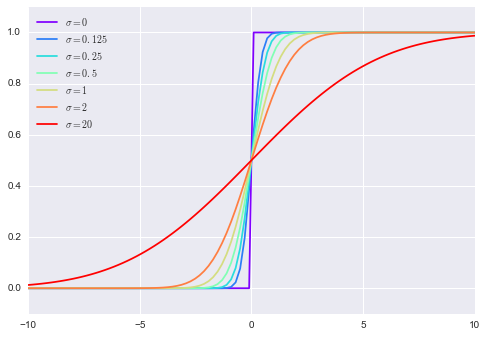

In [1]:
%matplotlib inline
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import seaborn as sns

def phi(x, mu, std):
    '''Cumulative distribution function for normal distributions with zero mean'''
    return (1.0 + math.erf( (x - mu) / np.sqrt(std * 2.0))) / 2.0

std_vals = [np.finfo(float).eps, 1/8, 1/4, 1/2, 1, 2, 20]
tol = 1e-10
x_vals = np.linspace(-10, 10, 100)
colors = iter(cm.rainbow(np.linspace(0, 1, len(std_vals))))
for i, std in enumerate(std_vals):
    color = next(colors)
    cdf_vals = np.array([phi(x, 0, std) for x in x_vals])
    plt.plot(x_vals, cdf_vals, color = color, label='$\sigma={}$'.format(std if std > tol else 0))
    plt.ylim(-0.1, 1.1)
    plt.legend(loc = 'upper left')

从图中可以看出：  
1）当$\sigma=0.125,0.25,1,2$时，分布函数为“S”形的曲线；  
2）当$\sigma\to 0$时，分布函数退化为阶跃函数；  
若$t\neq \mu$，则$-\frac{1}{2\sigma^2}(x-\mu)^2\to -\infty$，故$\mathcal{N}(t|\mu,\sigma^2)\to 0$  
若$t=\mu$，则$-\frac{1}{2\sigma^2}(x-\mu)^2=0$，故$\mathcal{N}(t|\mu,\sigma^2)\to +\infty$  
这种情况下，无论怎么采样，观察值都会落在均值上。  
3）当$\sigma=20$时，分布函数逐渐退化为直线。更极端一点，$\sigma\to \infty$的时候，分布函数会逐渐趋近于平行于水平轴线（即均匀分布），这时候进行采样的话，落在哪个点都是等可能的。

根据高斯分布的cdf，我们可以推导出它的quantile function（inverse cdf）为
$$x=\sigma  \sqrt{2}{erf}^{-1}(2\Phi-1) + \mu$$
我们试着在$[0, 1]$的均匀分布上独立同分布地分别采样一组（$[100,100,10000,100000]$）概率值，并利用上式计算这组概率在标准高斯分布中对应的分位点，然后画出这组样本点的密度函数：

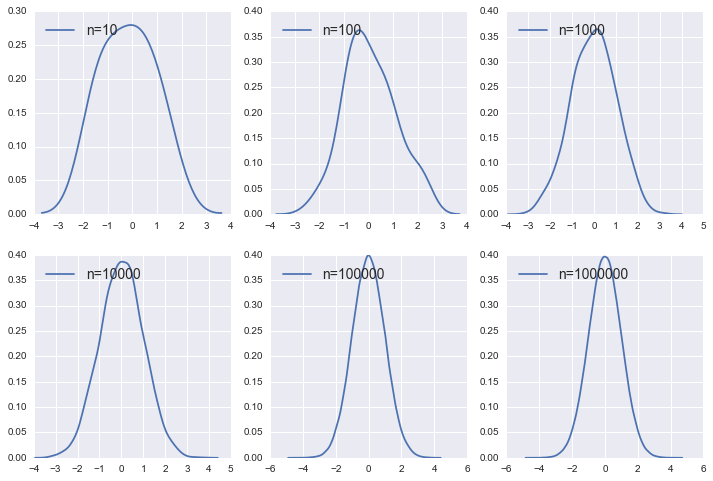

In [2]:
from scipy.special import erfinv
def gaussian_inv_cdf(phi, mu, std):
    return std * np.sqrt(2) * erfinv(2 * phi - 1) + mu

mu, std = 0, 1
fig, axes = plt.subplots(2, 3, figsize = (12, 8))
axes = np.ravel(axes)
nb_observations = [10 ** pow for pow in range(1, 7)]
for i, ax in enumerate(axes):
    u = np.random.uniform(0, 1, nb_observations[i])   
    sns.distplot(gaussian_inv_cdf(u, mu ,std), ax = ax, hist=False, label="n={}".format(nb_observations[i]))
    ax.legend(loc=2, prop={'size':14})    
plt.show()

当我们采样10个点，我们发现密度已经有点高斯的雏形了，但是它的mode和0还是有点偏差；当我们采样100个点，可以发现mode和0已经相差无几；根据这六张图我们可以得出结论，随着观察值的逐渐增加，密度函数越来越接近真实的高斯，而这个现象也从计算机模拟的角度验证了大数定律的正确性。

### 另一个例子
下面结合另一个例子来说明inverse cdf方法的工作原理。假设我们有如下的pdf：  
$$\begin{aligned}
h(x) &= \frac{2m^2}{(1-m^2)x^3} \mathbb{I}\{x \in [m,1]\}
\end{aligned}$$

可以求得它的cdf为：
$$\begin{aligned}
H(x) &= \int_{-\infty}^x h(t) dt\\
 &= \left\{
 \begin{array}{ll}
   0 , & \text{if} \; x < m\\
   \frac{1}{1-m^2} - \frac{m^2}{(1-m^2)x^2} , & \text{if} \; x \in [m,1]\\
   1 , & \text{if} \; x > 1
 \end{array}
\right.
\end{aligned}$$
对于$u\in[0,1]$，它的cdf为
$$\begin{aligned}
H^{-1}(u) &= \sqrt{\frac{m^2}{1-(1-m^2)u}}
\end{aligned}$$
我们可以画出$m=0.5$时该分布的图像：

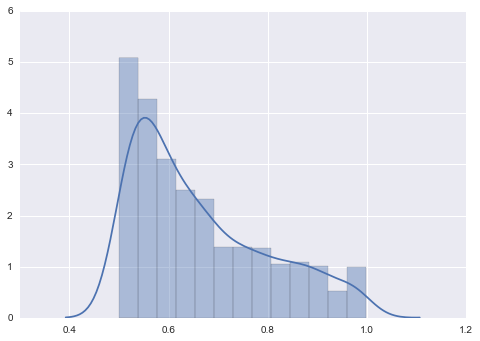

In [3]:
import numpy as np
import seaborn as sns
def inv_cdf(u, m):
    return np.sqrt(m ** 2 / (1 - (1 - m ** 2) * u))
u = np.random.uniform(0, 1, 1000)
sns.distplot(inv_cdf(u, .5))
plt.show()

## 拒绝采样（Rejection sampling）
上节我们介绍了逆变换采样，这个方法确实奏效，然而此方法只能采样一些简单的分布。对于一些pdf的积分无法计算或者cdf的反函数很难求的情况，逆变换采样就心有余而力不足了。而本节介绍的拒绝采样则对分布的形式不作任何的限制， 因而可以认为是一种比较通用的采样方法。  
我们先来看下面这张图，读懂了这张图就理解了拒绝采样。图中绿色的分布$p(x)$表示我们要采样的分布，红色的分布$Mq(x)$是一个辅助分布。可以看到红色分布完全把绿色分布“罩住”了，这里可能就有人要问了，为什么$q(x)$要乘一个$M$呢？ 这是因为仅仅用$q(x)$是无法完全将$p(x)$罩住的，我们知道分布的积分必须等于1， 如果在任意的点$x$上都有$q(x)>p(x)$的话，$q(x)$的积分就会大于1了，所以虽然可能有些地方$q(x)$要比$p(x)$高，那么就必然要在一些地方比$p(x)$低。乘以$M$是为了保证$q(x)$一定能在$p(x)$的上方。
<img src="http://7xikew.com1.z0.glb.clouddn.com/20160515004855367.png" width="500">
拒绝采样，顾名思义，就是有拒绝地采样，如果符合条件，我们就接受；不符合条件，我们就拒掉。那么接受的条件是什么？  
我们从分布$q(x)$随机采样生成一个点$x^{(i)}$，接着在$[0, Mq(x)]$上的均匀分布采样一个点$u$，如果$p(x^{(i)})<u<Mq(x)$我们就把它拒掉，如果$u$落在$(0, p(x^{(i)})$之间我们就接受。当然我们也可以在一个$U(0, 1)$的均匀分布上进行抽样，只要适当修改一下接受的条件就可以了：  
若$0<u<\frac{p(x^{(i)})}{Mq(x^{(i)})}$，则接受；否则，若$\frac{p(x^{(i)})}{Mq(x^{(i)})}<u<1$就拒绝  
我们经常将$\alpha=\frac{p(x^{(i)})}{Mq(x^{(i)})}$称为接受概率，即小于这个概率我们就接受，否则就拒掉。  
为什么拒绝采样能够工作？  
从图中我们可以很直观地感受出来，对于$p(x)$和$Mq(x)$接近的地方，接受率$\alpha$比较高，样本被接受的可能性就较大；而对于$p(x)$的概率密度较低的一些点，$p(x)$和$Mq(x)$相差比较大，这时接受率就比较低，很有可能被拒绝。



### 用Rejection sampling采样高斯分布
接下来我们用Rejection sampling来对标准高斯分布进行采样，假定$q(x)$是$[-5,5]$上的均匀分布，我们通过选取特定的$M$将$Mq(x)$固定为0.5：

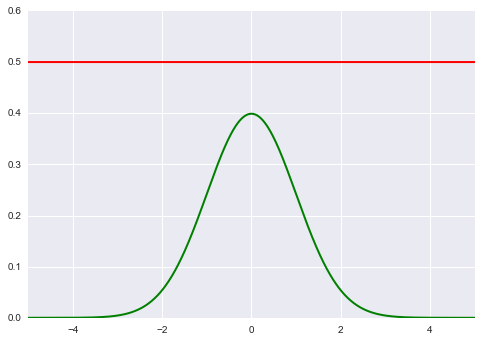

In [4]:
def gaussian(x, mu, std):
    return 1 / (np.sqrt(2 * np.pi) * std) * np.exp(-1 / (2 * std ** 2) * (x - mu) ** 2)
def Mq(x):
    return np.ones_like(x) * 0.5

x = np.linspace(-5, 5, 10000)
fig, ax = plt.subplots(1, 1)
ax.plot(x, gaussian(x, mu, std), c = 'g', lw=2)
ax.plot(x, Mq(x), c = 'r', lw=2)
ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.6)
plt.show()

接着我们实现rejection sampling并进行采样

Number of observations = 10, Accept rate = 0.1998001998
Number of observations = 100, Accept rate = 0.1899810019
Number of observations = 1000, Accept rate = 0.188998110019
Number of observations = 10000, Accept rate = 0.1985998014
Number of observations = 100000, Accept rate = 0.200879979912
Number of observations = 1000000, Accept rate = 0.199768998002


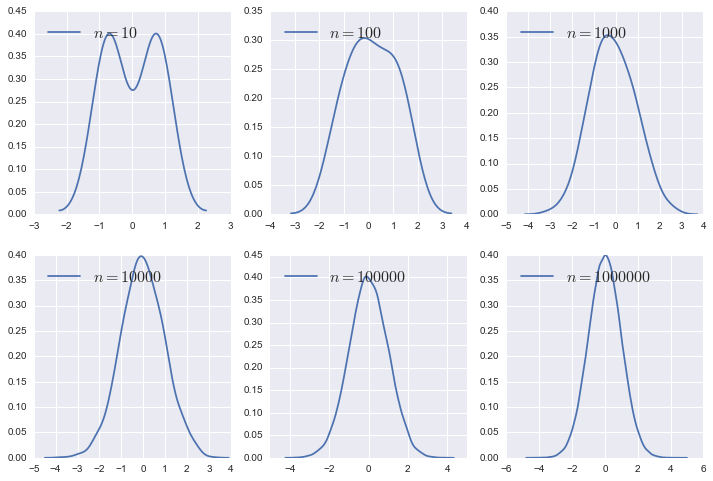

In [5]:
def rejection_sampling(sample):
    u = np.random.uniform(0, 1, len(sample))
    accept_rate = gaussian(sample, mu, std) / Mq(sample)
    return sample[u < accept_rate]
    
fig, axes = plt.subplots(2, 3, figsize = (12, 8))
axes = np.ravel(axes)
nb_observations = [10 ** pow for pow in range(1, 7)]
for i, ax in enumerate(axes):
    sample = np.random.uniform(-5, 5, nb_observations[i])    
    sample_accepted = rejection_sampling(sample)    
    sns.distplot(sample_accepted, ax = ax, hist=False, label="$n={}$".format(nb_observations[i]))
    ax.legend(loc=2, prop={'size':16})
    print "Number of observations = {0}, Accept rate = {1}".format(nb_observations[i], len(sample_accepted) / (len(sample) + 0.01))

从上图我们能够发现，随着观察值的不断增加，样本的密度函数不断接近于高斯分布，并且接受率稳定在0.2左右。相比于逆变换采样，拒绝采样是一种更general的方法，但它的缺点是效率低，为了说明这个问题，我将$Mq(x)$人为抬高到0.8来看看会发生什么：

In [6]:
def Mq(x):
    return np.ones_like(x) * 0.8

nb_observations = [10 ** pow for pow in range(1, 7)]
for n in nb_observations:
    sample = np.random.uniform(-5, 5, n) 
    sample_accepted = rejection_sampling(sample)   
    print "Number of observations = {0}, Accept rate = {1}".format(n, len(sample_accepted) / (len(sample) + 0.01))

Number of observations = 10, Accept rate = 0.0
Number of observations = 100, Accept rate = 0.1099890011
Number of observations = 1000, Accept rate = 0.113998860011
Number of observations = 10000, Accept rate = 0.1238998761
Number of observations = 100000, Accept rate = 0.123919987608
Number of observations = 1000000, Accept rate = 0.125399998746


我们可以发现，当$Mq(x)=0.8$时，接受率显著降低。因此，如果我们用来包裹$p(x)$的辅助分布$Mq(x)$选择的不好（比如$q(x)$密度高的地方$p(x)$密度刚好很低），又或者$p(x)$本身就很坑（比如$\sigma^2$非常大的高斯分布），我们再用拒绝采样去做sampling的话，就会出现接受率很低的情况，这就导致一次采样过程中有很大部分样本被拒掉，从而降低整体采样效率。

## 自适应拒绝采样（Adaptive rejection sampling）
鉴于效率问题，一般问题中很少用到拒绝采样，但是它的一个变种—— 自适应拒绝采样（Adaptive rejection sampling）却是经常用到的方法。自适应拒绝采样适用于$p(x)$是log-concave的情况。简要回顾一下concave函数（这里仅考虑一元变量的情况，多元变量的情况可以很容易地得到推广），给定实数域上任意两个点$x,y\in\mathbb{R}$和函数$f:\mathbb{R}\to \mathbb{R}$，如果对于任意的$\theta\in[0,1]$下式都成立：
$$f(\theta x +  (1-\theta)y) \geq \theta x +  (1-\theta)y $$
则称函数$f(x)$是*凹函数*（*concave function*），而如果$\log f(x)$是concave函数，我们则称$f(x)$是log-concave函数。  
举个log-concave函数的例子，我们分别画出$Beta(2, 3)$和其对数的图像：

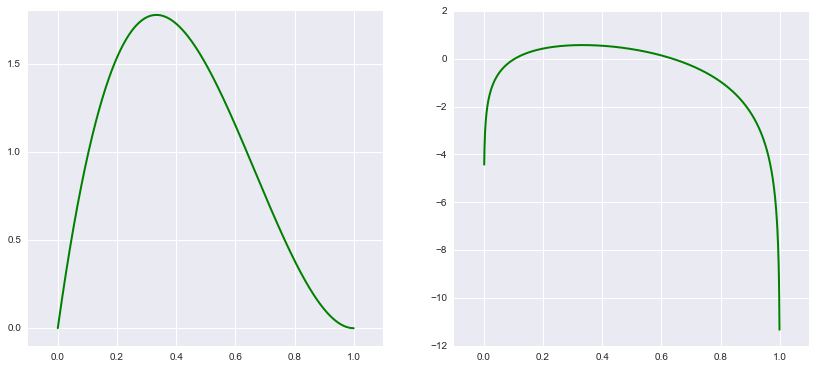

In [7]:
from scipy.stats import beta

x = np.linspace(0, 1, 1000)
rv = beta(2, 3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(x, rv.pdf(x), 'g-', lw=2)
ax1.set_xlim(-.1, 1.1)
ax1.set_ylim(-.1, 1.8)

ax2.plot(x, np.log(rv.pdf(x)), 'g-', lw=2)
ax2.set_xlim(-.1, 1.1)
ax2.set_ylim(-12, 2)
plt.show()

从上图我们看到$Beta(2, 3)$不是concave的，但它的对数则是concave函数，因此$Beta(2, 3)$是log-concave函数。

### Adaptive rejection sampling的原理

这一节我们将结合高斯分布来阐明Adaptive rejection sampling算法（以下简称ARS）的工作原理。从高斯分布的图像很容易看出，它并不是concave的，但是我们可以证明它是log-concave的：
$$ \log p(x)=\log \frac{1}{\sqrt{2\pi}\sigma}\exp\big\{-\frac{1}{2\sigma^2}(t-\mu)^2\big\} = -\log (\sqrt{2\pi}\sigma) -\frac{1}{2\sigma^2}(t-\mu)^2$$
注意到$\log p(x)$是一个二次函数，因此我们知道高斯分布是log-concave的。我们进一步可以画出该抛物线的图像：

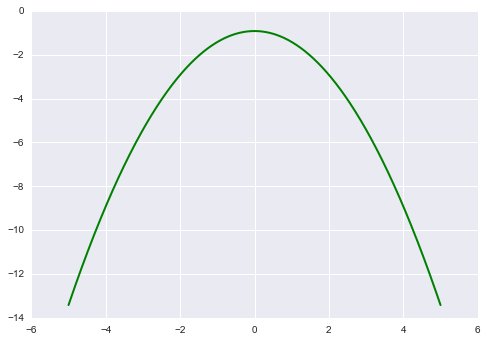

In [8]:
def log_gaussian(x, mu, std):
    return -np.log(np.sqrt(2 * np.pi) * std) - 1 / (2 * std ** 2) * (x - mu) ** 2

x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 1)
ax.plot(x, log_gaussian(x, mu, std), 'g-', lw=2)
plt.show()

接着我们挑选3个点作为起始点，画出经过这些点的切线

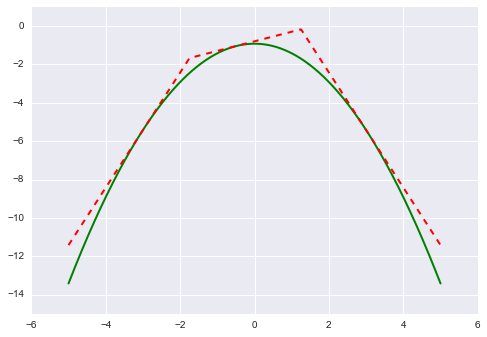

In [9]:
def get_slope(x, mu, std):
    return -1 / (std ** 2) * x + mu / (std ** 2)

def linear_fit(x, k, x0, y0):
    return k * (x - x0) + y0

def intersection(x0, y0, x1, y1, k0, k1):
    '''Intersection of two lines'''
    x = (y0 - y1 - k0 * x0 + k1 * x1) / (k1 - k0)
    y = k0 * (x - x0) + y0
    return x, y
    
def piecewise_linear(x, x0, y0, x1, y1, x2, y2, k0, k1, k2):
    '''piecewise linear function'''
    return np.piecewise(x, [x < x0, x >= x0, x >= x1], [lambda x: linear_fit(x, k0, x0, y0), lambda x: linear_fit(x, k1, x1, y1), lambda x: linear_fit(x, k2, x2, y2)])

x = np.linspace(-5, 5, 1000)
fig, ax = plt.subplots(1, 1)
ax.plot(x, log_gaussian(x, mu, std), 'g-', lw=2)
x_pick = np.array([-3, -.5, 3])
y_pick = log_gaussian(x_pick, mu, std)
slope = get_slope(x_pick, mu, std)

# non-piecewise version:
#for x0, y0, slp in zip(x_pick, y_pick, slope):
#   ax.plot(x, linear_fit(x, slp, x0, y0), 'r--')

# piecewise version:
k0, k1, k2 = slope[0], slope[1], slope[2]
x0, y0 = intersection(x_pick[0], y_pick[0], x_pick[1], y_pick[1], k0, k1)
x1, y1 = intersection(x_pick[1], y_pick[1], x_pick[2], y_pick[2], k1, k2)
x2, y2 = x_pick[2], y_pick[2]
ax.plot(x, piecewise_linear(x, x0, y0, x1, y1, x2, y2, k0, k1, k2), 'r--', lw=2)

ax.set_ylim(-15, 1)
plt.show()

我们看到，这三条切线构成的分段线性函数（piecewise linear function）牢牢地将抛物线包住，这正是我们完美的$q(x)$，然而别忘了这是在对数空间，我们还要把它们映射回原空间。对数空间下是一个直线$y=mx+b$，原空间下就是一个指数函数$\exp(mx+b)$，那么对数空间中的分段线性函数映射回原空间就是分段指数函数（piecewise exponential function）：

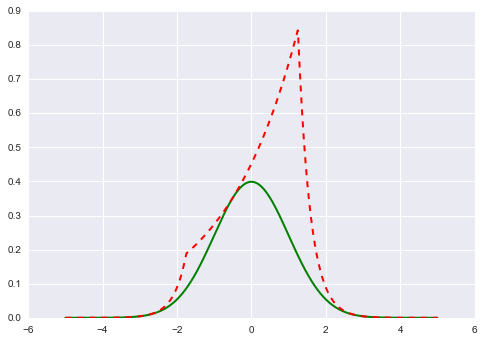

In [10]:
def piecewise_exponential(x, x0, y0, x1, y1, x2, y2, k0, k1, k2):
    '''piecewise linear function'''
    return np.exp(np.piecewise(x, [x < x0, x >= x0, x >= x1], [lambda x: linear_fit(x, k0, x0, y0), lambda x: linear_fit(x, k1, x1, y1), lambda x: linear_fit(x, k2, x2, y2)]))

fig, ax = plt.subplots(1, 1)
ax.plot(x, gaussian(x, mu, std), 'g-', lw=2)

# non-piecewise version:
#for x0, y0, slp in zip(x_pick, y_pick, slope):
#    ax.plot(x, np.exp(linear_fit(x, slp, x0, y0)), 'r--')

# piecewise version:
ax.plot(x, piecewise_exponential(x, x0, y0, x1, y1, x2, y2, k0, k1, k2), 'r--', lw=2)
ax.set_ylim(0, .9)
plt.show()

图中高斯分布被分段指数函数完全包住。此外需要注意的是，不要认为红色虚线是指数分布的密度函数，它与水平轴之间的面积实际上大于1。接下来我们多生成几个点，看看会发生什么：  


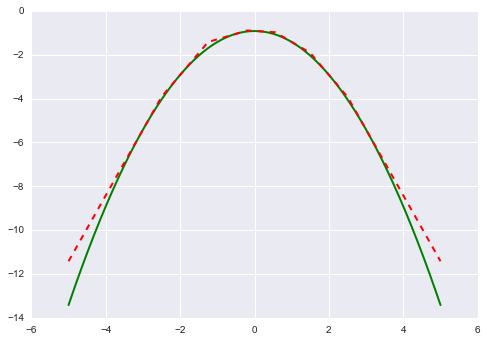

In [11]:
def piecewise_intersections(data, log_pdf, log_dev):
    '''Calculate the intersections of the piecewise linear function 
    # Arguments:
        data: a set of data points x1, x2, ... ,xk
        log_pdf: log density function
        log_dev: derivative of log_pdf
    # Returns:
        (z, fz): coordinates of k - 1 meet points of the piecewise linear function
    '''
    # sort data
    data = np.sort(data)
    z = []
    for j in range(len(data) - 1):
        z.append((log_pdf(data[j + 1]) - log_pdf(data[j]) - log_dev(data[j + 1]) * data[j + 1] + log_dev(data[j]) * data[j]) / (log_dev(data[j]) - log_dev(data[j + 1])) )
    z = np.array(z, dtype='float32')
    fz = log_dev(data[:-1]) * (z - data[:-1]) + log_pdf(data[:-1]) 
    return (z, fz) 

def piecewise_linear_multi(x, data, log_pdf, log_dev):
    '''Piecewise linear function that can deal with input sequences of any length
    # Arguments:
        x: input points to predict
        data: a set of data points x1, x2, ... ,xk
        calculate z1, z2, ..., z_{k-1}, xk
    # Returns:
        multipart plepiece wise linear function
    '''
    # sort data
    data = np.sort(data)
    z, fz = piecewise_intersections(data, log_pdf, log_dev)
    condlist = []
    condlist.append(x < z[0])
    for i in range(len(z)):
        condlist.append(x >= z[i])
    funclist = [lambda x, i = i: linear_fit(x, log_dev(data)[i], data[i], log_pdf(data)[i]) for i in range(len(data))]
    return np.piecewise(x, condlist, funclist)

def log_gaussian_dev(x, mu, std):
    return -1 / std ** 2 * (x - mu)

log_pdf = lambda x, mu = mu, std = std: log_gaussian(x, mu, std)
log_dev = lambda x, mu = mu, std = std: log_gaussian_dev(x, mu, std)
x_pick2 = np.array([-2, 0.1, 1, 2])
x_pick2 = np.concatenate((x_pick, x_pick2))
fig, ax = plt.subplots(1, 1)
ax.plot(x, log_gaussian(x, mu, std), 'g-', lw=2)
ax.plot(x, piecewise_linear_multi(x, x_pick2, log_pdf, log_dev), 'r--', lw=2)
plt.show()

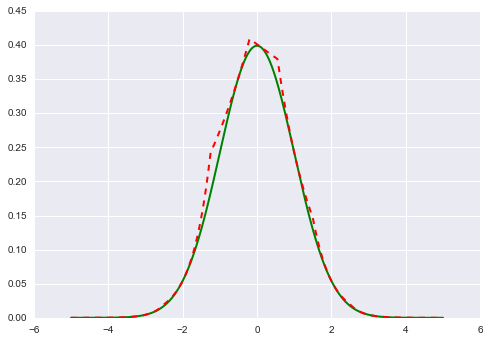

In [12]:
def piecewise_exp_multi(x, data, log_pdf, log_dev):
    '''Piecewise exponential function that takes as input any length of sequence'''
    return np.exp(piecewise_linear_multi(x, data, log_pdf, log_dev))

fig, ax = plt.subplots(1, 1)
ax.plot(x, gaussian(x, mu, std), 'g-', lw=2)
ax.plot(x, piecewise_exp_multi(x, x_pick2, log_pdf, log_dev), 'r--', lw=2)
plt.show()


我们发现，增加几个点后得到的分段指数函数将高斯分布包裹的更紧了。随着采样点的增加，分段指数函数会将高斯分布包的越来越紧，这就是ARS算法的核心思想。值得注意的是这里我为了达到演示效果充当了人工采样器，手动挑了几个点，在算法的实际工作过程中，应该用分段指数分布的inverse cdf来采样。

下面我将重点叙述ARS算法的工作流程，首先定义要用到的符号：  
* $h(x)$：对数概率密度函数（log-pdf） 
* $h'(x)$：对数概率密度函数的导数  
* $z_j\ (\ j=1,2,...,k-1)$：分段线性函数的第$j$个交点，定义$z_0=left\_bound$，$z_k=right\_bound$
* $u_j(x)$：分段线性函数在区间$[z_{j-1},z_j]$上的函数值，$u_j(x) = h(x_j) + h'(x_j) (x-x_j), x\in [z_{j-1},z_j]$  
* $s_k(x)=\frac{\exp(u_k(x))}{\int \exp(u_k(t)) dt}$： 分段指数概率密度函数  

$u_j(x)$可以表示为
$$u_j(x)=m_j x + b_j$$
其中：  
* $m_j$：区间$[z_{j-1},z_j]$上直线的斜率，$m_j=h'(x_j)$
* $b_j$：区间$[z_{j-1},z_j]$上直线的截距，$b_j=h(x_j)-x_j h'(x_j)$


ARS算法的步骤如下：  
1）选择$\{x_1,x_2,...,x_k\}$作为$k$个起始点  
2）计算分段线性函数的边界点：
$$z_j=\frac{h(x_{j+1})-h(x_j) - x_{j+1}h'(x_{j+1}) + x_j h'(x_j)}{h'(x_j)-h'(x_{j+1})}$$
3）根据边界点计算每条直线的斜率和截距$m_j, b_j(j=1,2,...,k)$  
$$m_j=h'(x_j)\\ b_j=h(x_j)-x_j h'(x_j)$$
4）计算每个区间上的面积
$$a_j=\int_{z_{j-1}}^{z_j} \exp(m_j t + b_j) dt=\frac{\exp(b_j)}{m_j}[\exp(m_j z_j)-\exp(m_j z_{j-1})]$$
5）计算伪cdf
$$F(z_i) = \sum_{j=0}^i a_j,(i=1,2,...,k)$$
之所以称作伪cdf是因为它不是真正的cdf，但是它与$P(x\leq z_i)$成正比，唯一的区别就是未作归一化处理  
6）从均匀分布$U(0, F(z_k))$采样一个$u^*$，并确定$u^*$所在的区间，设$ind$为$u^*$所在区间的右端点的下标（以下简记为$i$）  
7）假设$u^*\in [F(z_{i-1}), F(z_{i})]$，我们的目标是找出$x^*=F^{-1}(u^*)$，由分布函数的单调性可知，$x^*$必定落在$z_{i-1}, z_{i}$  
根据定义我们有
$$\begin{aligned}u^*&=\int_{z_0}^{x^*} exp(mt+b)dt\\& = F(z_{i-1}) + \int_{z_{i-1}}^{x^*}\exp(m_{i} t+b_i)dt\\&=F(z_{i-1})+\frac{\exp(b_i)}{m_i}[\exp(m_i x^*)-\exp(m_i z_{i-1})]\end{aligned}$$
从而
$$\begin{aligned}x^*&=\frac{1}{m_i}\log\big[\exp(m_i z_{i-1})+\frac{m_i u^*-m_i F(z_{i-1})}{\exp(b_i)}\big]\\&=\frac{1}{m_i}\log\big[\exp(m_i z_{i-1})+\frac{m_i u_L}{\exp(b_i)}\big]\end{aligned}$$
其中$u_L=u^*-F(z_{i-1})$  
8）采样$u\sim U(0,1)$，如果$u<\frac{p(x^*)}{\exp(m_i x^*+b_i)}$则接受$x^*$，否则拒绝$x^*$

### ARS实现
这一节我们根据上一节介绍的流程，将ARS算法用python实现。

accept rate:0.999900009999


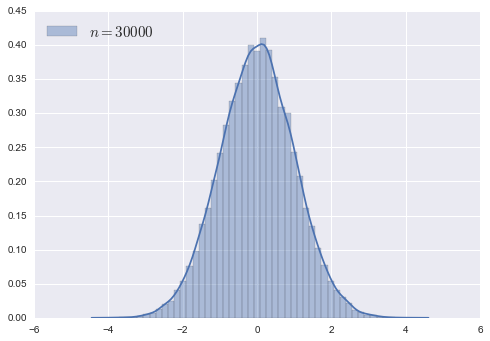

In [13]:
def update_piecewise_exp(data, log_pdf, log_dev):
    '''Update the piece-wise envelope in the log-space
    # Arguments:         
        data - the sampled points (unsorted)
        log_pdf - the log of the pdf
        log_dev - the derivative of log(pdf)
    # Returns: 
        data - the sampled points (sorted)
        fd - log(pdf(data))
        z, fz - intersection points
        m, b - slope and intecept of tangenet       
    '''
    # sort data
    data = np.sort(data)
    fd = log_pdf(data)
    # calculate meet points
    z, fz = piecewise_intersections(data, log_pdf, log_dev)
    # calculate slope and intercept
    m = log_dev(data)
    b = log_pdf(data) - data * log_dev(data)
    return data, fd, z, fz, m, b

def ARS(pdf, log_pdf, log_dev, init_points, max_accepted = 100, bounds = (-np.inf, np.inf)):
    '''Adaptive rejection sampling
    # Arguments:         
        pdf - the probability distribution function(pdf)
        log_pdf - the log of the pdf
        log_dev - the derivative of log(pdf)  
        init_points - initial points
        max_accepted - number of max accepted points
        bounds - the (min, max) range of x drawing samples from
    # Returns:
        sample_accepted - accepted samples
        num_sampled - number of sampled points
    '''
    x = init_points
    num_sampled = 0
    num_accepted = 0
    sample_accepted = []
    x, fx, z, fz, m, b = update_piecewise_exp(x, log_pdf, log_dev)
    # calculate cdf
    left_bounds = np.append(bounds[0], z)
    right_bounds = np.append(z, bounds[1])
    c = np.exp(b) / m * (np.exp(m * right_bounds) - np.exp(m * left_bounds))
    cdf = np.cumsum(c)
    while num_accepted < max_accepted:
        # perform inverse transform sampling
        u_star = np.random.uniform(0, cdf[-1])
        ind = np.argmax(cdf >= u_star)
        # left bound of the interval that u_star falls into
        if ind == 0:
            L_int = 0
        else:
            L_int = cdf[ind - 1]
        uL = u_star - L_int
        x_star = 1 / m[ind] * np.log(np.exp(m[ind] * left_bounds[ind]) + m[ind] * uL / np.exp(b[ind]))
        # sample from U(0, 1)
        u = np.random.uniform(0, 1)
        if u < (pdf(x_star) / np.exp(m[ind] * x_star + b[ind])):
            sample_accepted.append(x_star)
            num_accepted += 1
        # update the envelop to include x*
        x, fx, z, fz, m, b = update_piecewise_exp(np.append(x, x_star), log_pdf, log_dev)
        left_bounds = np.append(-np.inf, z)
        right_bounds = np.append(z, np.inf)
        c = np.exp(b) / m * (np.exp(m * right_bounds) - np.exp(m * left_bounds))
        cdf = np.cumsum(c)      
        num_sampled += 1
    return sample_accepted, num_sampled 
        
pdf = lambda x, mu = mu, std = std: gaussian(x, mu, std)
log_pdf = lambda x, mu = mu, std = std: log_gaussian(x, mu, std)
log_dev = lambda x, mu = mu, std = std: log_gaussian_dev(x, mu, std)
init_points = np.array([-3, -.5, 3])
max_accepted = 30000
bounds = (-np.inf, np.inf)
sample_accepted, num_sampled = ARS(pdf, log_pdf, log_dev, init_points, max_accepted = max_accepted, bounds = bounds)
print "accept rate:{}".format(max_accepted / num_sampled)
fig, ax = plt.subplots(1, 1)
sns.distplot(sample_accepted, ax = ax, label="$n={}$".format(max_accepted))
ax.legend(loc=2, prop={'size':15})
plt.show()

可以看到，ARS接受率接近于1，在3万的采样次数下结果的密度曲线已经相当靠近高斯分布了。

## 参考
1. [http://blog.csdn.net/baimafujinji/article/details/51407703](http://blog.csdn.net/baimafujinji/article/details/51407703)
2. [http://blog.quantitations.com/tutorial/2012/11/20/sampling-from-an-arbitrary-density/](http://blog.quantitations.com/tutorial/2012/11/20/sampling-from-an-arbitrary-density/)